In [151]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import requests
import json
import datetime
from IPython.display import Image


In [ ]:
#NOTES - To do:
# map of LMP locations
# log transform values (lmps, demand, wind?)
    # ignore nas - NOT replace with zero
    # first shift, then log transform, absolute value of smallest number plus 1
    # can shift each data series independently, not all together
    # must log transform, demand, wind generation, 
    # should be normally distributed after log transform
# coal: get delivered prices
# Daily averages 

# NOTES - presentation
# we are doing time-series analysis - not cross-sectional
# so we are forecasting. Our 'test' set is the forecast for demand, ng, etc. and our output variable is the electricity price
# this price will be the mean expected value of future electricity prices (at particular nodes)
# need to control for autocorrellation....

<img src="nukes.png">

## Read and format PJM LMPs

In [2]:
pjmdf = pd.read_csv('4. PJM Data/rawdf_pjm_dayahead.csv')
pjmdf.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
pjmdf.head()

,pnodeId,price_01,price_02,price_03,price_04,price_05,price_06,price_07,price_08,price_09,price_10,price_11,price_12,price_13,price_14,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24,publishDate
0,32417601,24.15,23.10,21.91,21.08,20.84,21.32,22.55,23.86,24.42,25.15,25.39,26.29,25.84,25.71,25.55,25.44,26.30,42.40,60.56,54.69,45.31,34.56,29.84,25.54,2008-01-01
1,32417601,26.43,25.70,25.58,25.27,25.53,30.45,55.32,66.16,70.70,66.22,63.54,53.78,46.65,44.25,39.70,37.93,40.74,81.39,96.11,82.96,74.83,62.65,50.67,37.44,2008-01-02
2,32417601,54.70,53.51,50.60,50.63,50.44,58.14,78.02,71.51,85.80,74.81,67.08,58.18,62.91,50.24,42.84,36.87,46.33,73.71,100.76,92.22,84.85,65.52,55.79,59.20,2008-01-03
3,32417601,52.28,46.93,44.46,42.24,43.48,55.10,72.56,84.60,91.68,76.72,65.81,60.11,60.58,48.12,37.86,30.72,39.32,55.88,93.76,75.07,58.56,58.50,48.51,33.22,2008-01-04
4,32417601,25.75,25.59,25.29,25.06,24.65,24.57,25.18,33.56,38.62,42.20,39.27,33.34,27.90,26.89,25.40,25.51,25.75,40.95,56.56,48.63,40.82,33.27,25.76,24.24,2008-01-05


In [3]:
# rearrange lmp dataframe to be indexed by date/hour, with 1 col per node
idx = pd.date_range('1/1/2008', '11/01/2015 23:00:00', freq = 'H')
lmpdf = pd.DataFrame(index = idx)

for node in pjmdf['pnodeId'].unique():
    nodedf = pjmdf[pjmdf['pnodeId']==node]
    #df = dfpn7601[:1460]
    nodedf = nodedf.drop('pnodeId',1)
    nodedf = nodedf.drop('publishDate',1)
    nodedf = nodedf.fillna(0)
    nodedf = nodedf.stack()
    col_name = 'lmp_' + str(node)[-3:]
    nodedf.index = idx
    lmpdf[col_name] = nodedf
lmpdf.head(2)

,lmp_601,lmp_635,lmp_525,lmp_547,lmp_629,lmp_633,lmp_599,lmp_527,lmp_545,lmp_631,lmp_673
2015-11-01 19:00:00,25.04,0.82,25.00,25.16,12.79,0.82,25.05,25.00,25.39,12.79,22.34
2015-11-01 20:00:00,24.63,2.56,24.54,24.80,12.81,2.56,24.63,24.53,25.04,12.81,22.41
2015-11-01 21:00:00,22.79,1.22,22.74,22.94,11.59,1.22,22.79,22.74,23.14,11.59,20.94
2015-11-01 22:00:00,21.01,-0.93,20.96,21.23,9.41,-0.93,21.01,20.96,21.42,9.41,20.18
2015-11-01 23:00:00,19.58,-2.08,19.54,19.76,8.31,-2.08,19.58,19.53,19.96,8.31,20.15


C:\Users\huntington\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


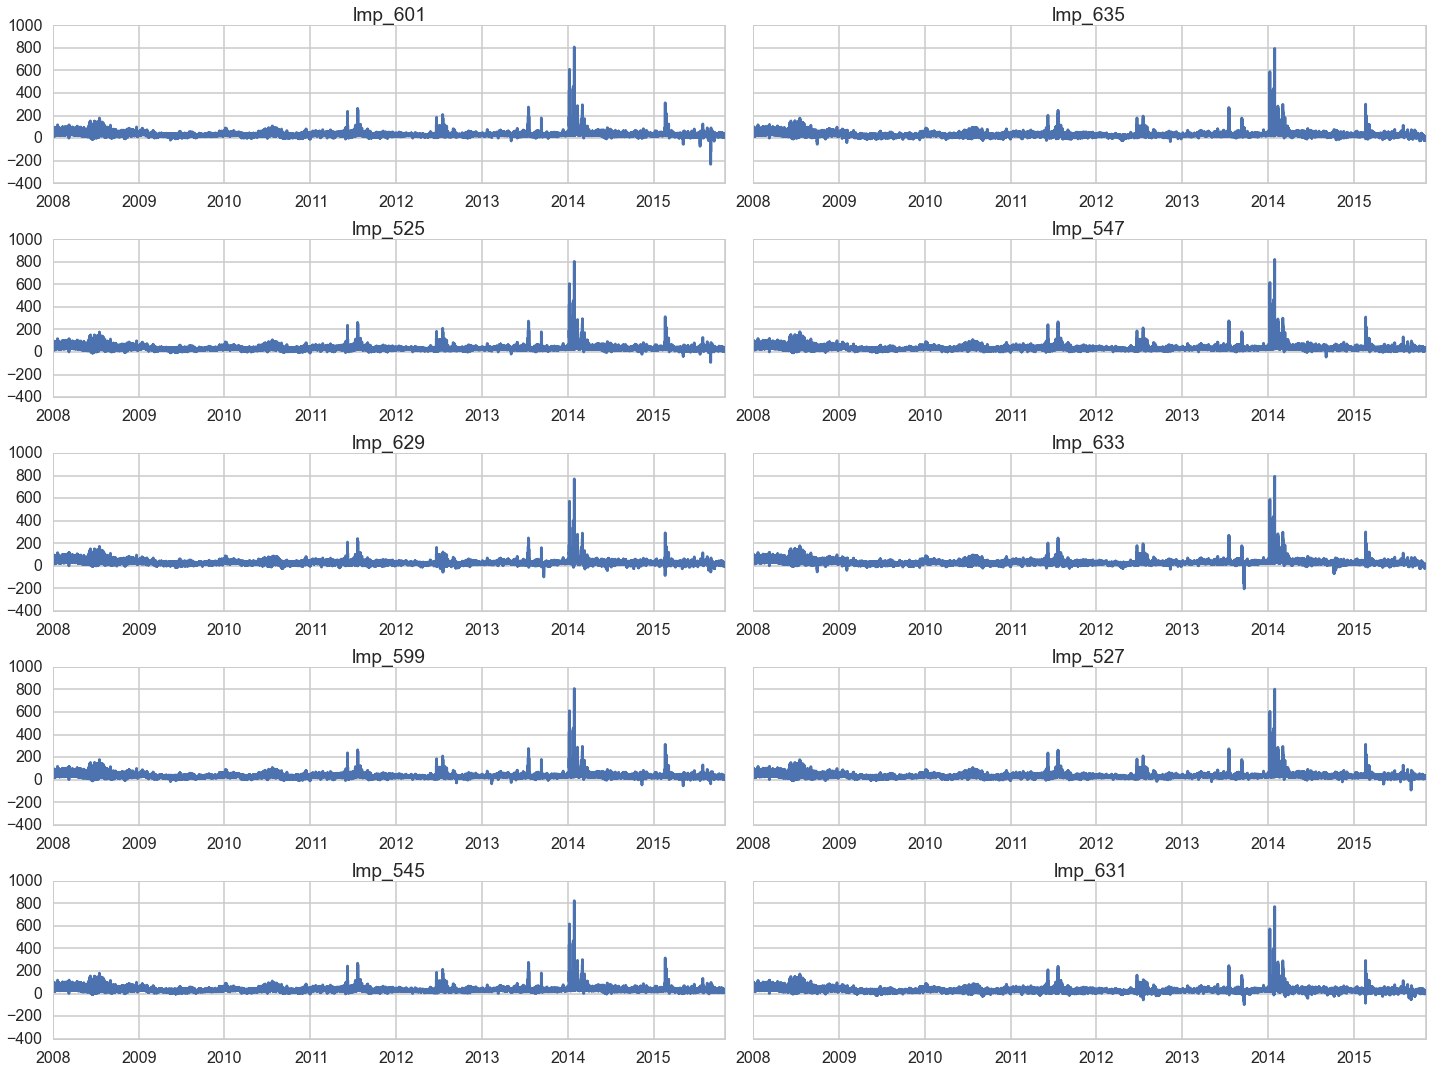

In [5]:
fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,15),tight_layout=True,sharey=True)
headers = list(lmpdf)
ax = axes.ravel()

for i in range(10):
    k = lmpdf.iloc[:,i]
    k.plot(ax=ax[i], title=headers[i])
    


## Read in and format PJM load data

In [6]:
ldf = pd.read_csv('data/PJM_hourly_load_08_15.csv')
#ldf = pjm_load[:1827] #5 yrs: 2008-2012
ldf = ldf.drop('DATE',1)
ldf = ldf.drop('COMP',1)
ldf = ldf.drop('Unnamed: 26',1)
ldf = ldf.drop('Unnamed: 27',1)
ldf = ldf.fillna(0)
ldf = ldf.stack()
idx = pd.date_range('1/1/2008', periods = len(ldf), freq = 'H')
ldf.index = idx

#trim it to appropirate length
d = '2015-11-01 23:00:00'
ldf = ldf.ix[:d]

C:\Users\huntington\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


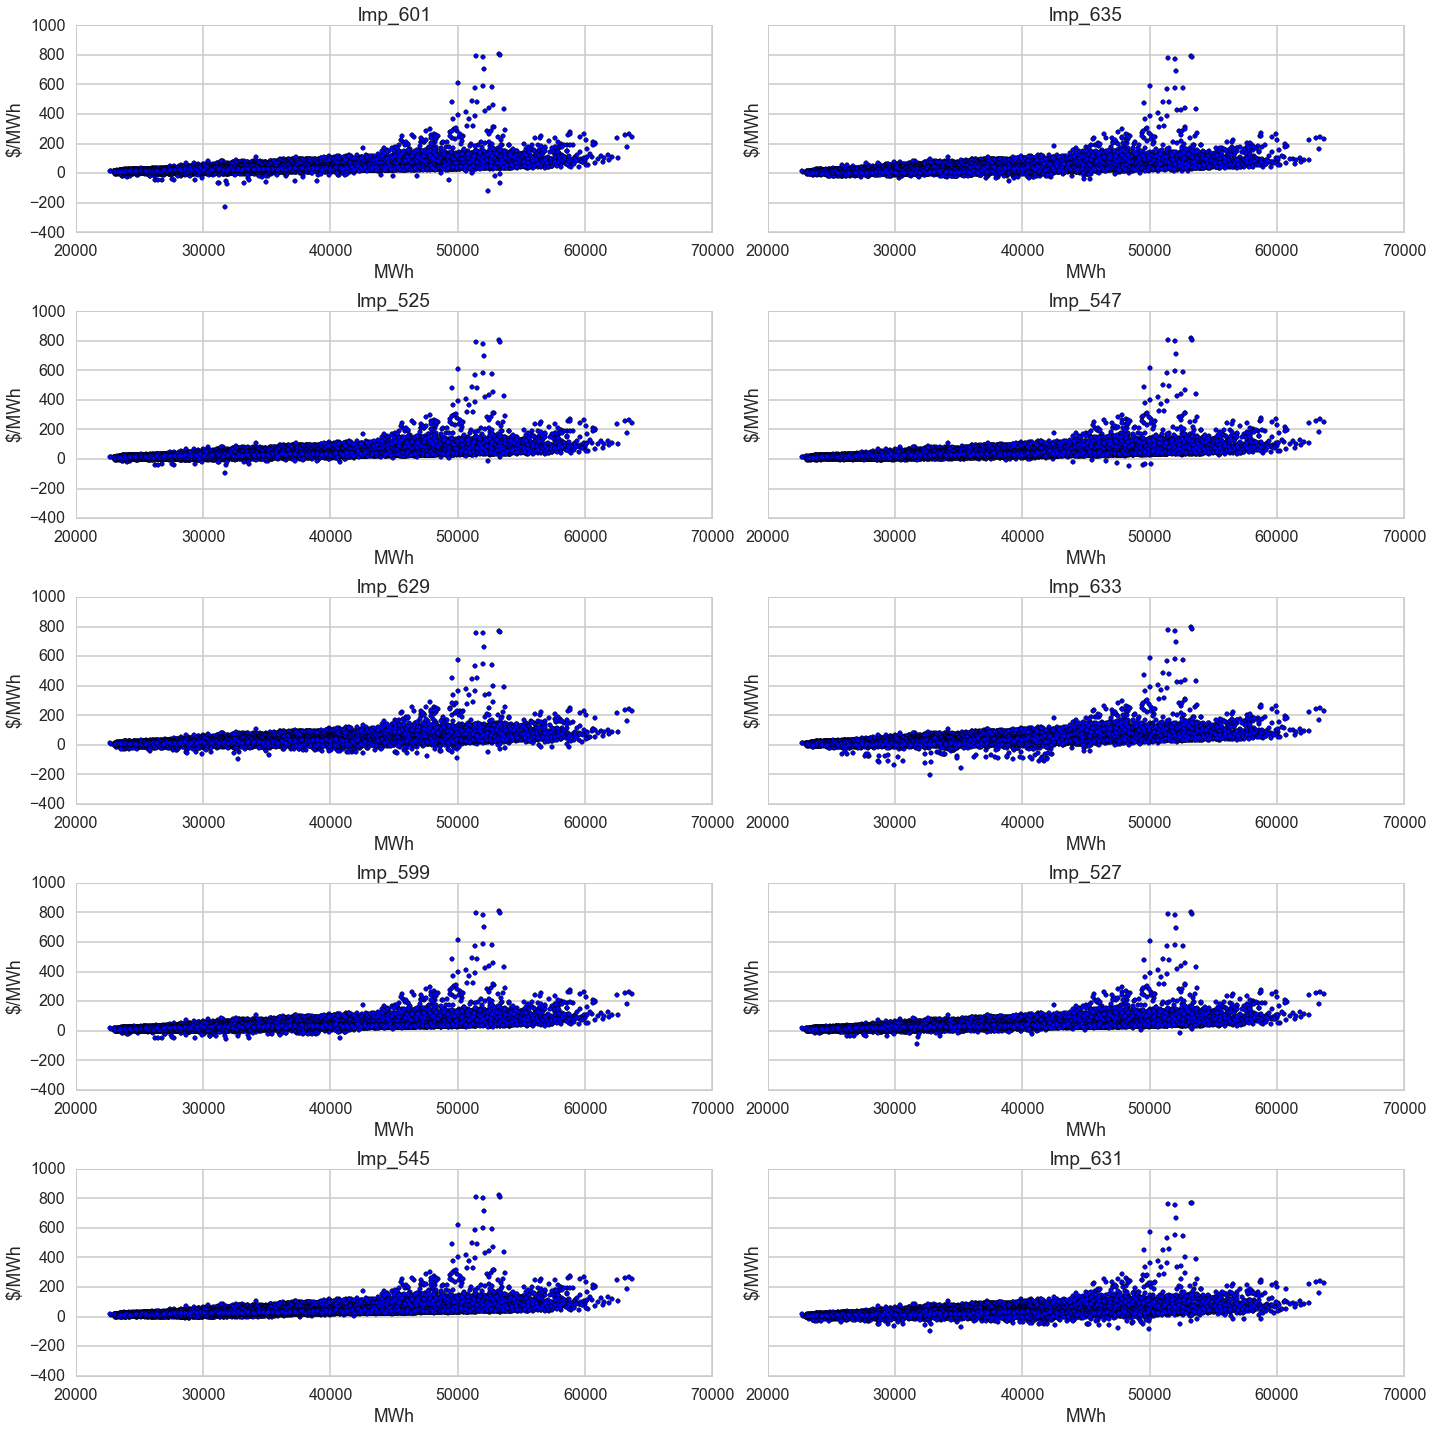

In [7]:
fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,20),tight_layout=True,sharey=True)
headers = list(lmpdf)
ax = axes.ravel()

for i in range(10):
    x = ldf
    y = lmpdf.iloc[:,i]
    ax[i].scatter(x,y)
    ax[i].set_title(headers[i])
    ax[i].set_xlim([20000,70000])
    ax[i].set_ylabel("$/MWh")
    ax[i].set_xlabel("MWh")
    


In [8]:
# fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,15),tight_layout=True,sharey=True)
# headers = list(lmpdf)
# ax = axes.ravel()

# for i in range(10):
#     lmpdf.iloc[:,i].hist(bins=100, ax=ax[i])
#    ax[i].set

# ldf.hist(bins=100)
# plt.title('Frequency of total demand')
# plt.xlabel('MWh of demand')
# plt.ylabel('# of hours')

## Read and Format PJM and MISO Wind Data

In [9]:
# PJM
pjm_wdf = pd.read_csv('data/PJM_Wind/PJM_hourly_wind_08_15.csv')
pjm_wdf = pjm_wdf.drop('DATE',1)
pjm_wdf = pjm_wdf.drop('COMP',1)
pjm_wdf = pjm_wdf.fillna(0)
pjm_wdf = pjm_wdf.stack()
num_hours = len(pjm_wdf)
idx = pd.date_range('1/1/2008', periods = num_hours, freq = 'H')
pjm_wdf.index = idx

# MISO
wdf = pd.read_csv('data/MISO_wind_hourly.csv')
wdf = wdf.drop('Date',1)
num_hours = len(wdf)
idx = pd.date_range('1/1/2008', periods = num_hours, freq = 'H')
wdf.index = idx


In [10]:
# Trim both data sets to an equal size
d = '2015-11-01 23:00:00'
pjm_wdf = pjm_wdf.ix[:d]
wdf = wdf.ix[:d]

# Merge into a single df
wdf['Wind_PJM'] = pjm_wdf
wdf.columns = ['Wind_MISO', 'Wind_PJM']
wdf.head()

,Wind_MISO,Wind_PJM
2008-01-01 00:00:00,1104.05,697.102
2008-01-01 01:00:00,1210.31,679.046
2008-01-01 02:00:00,1173.34,632.607
2008-01-01 03:00:00,1146.36,612.350
2008-01-01 04:00:00,1179.32,620.483


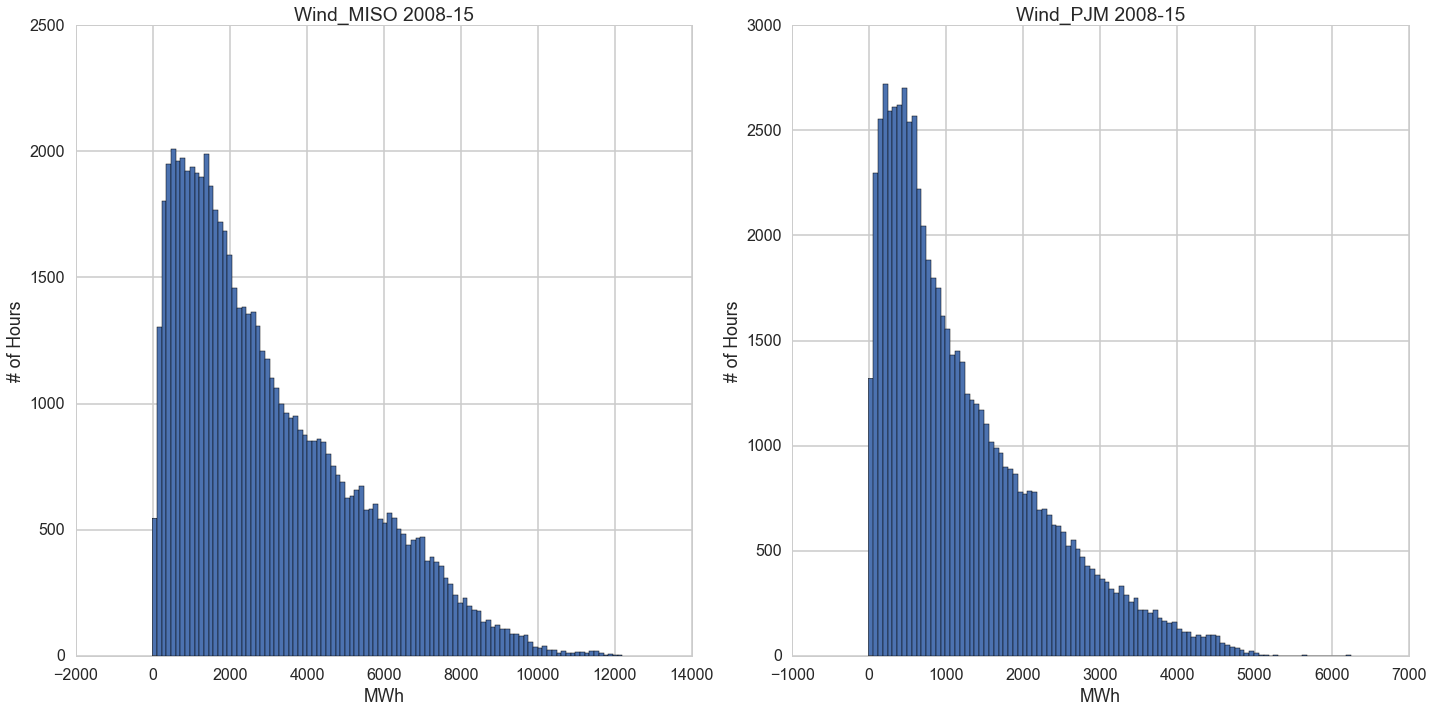

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10),tight_layout=True)
headers = list(wdf)
ax = axes.ravel()

for i in range(2):
    wdf.iloc[:,i].hist(bins=100, ax=ax[i])
    ax[i].set_title(headers[i] + ' 2008-15')
    ax[i].set_ylabel("# of Hours")
    ax[i].set_xlabel("MWh")
    #ax[i].scatter(x,y)

## Combine wind, load, and LMP data into single DF

In [12]:
d = '2015-11-01 23:00:00'
wdf_trim = wdf.ix[:d]
fulldf = pd.merge(lmpdf, wdf_trim, left_index=True, right_index=True)
fulldf['Load_PJM_West'] = ldf

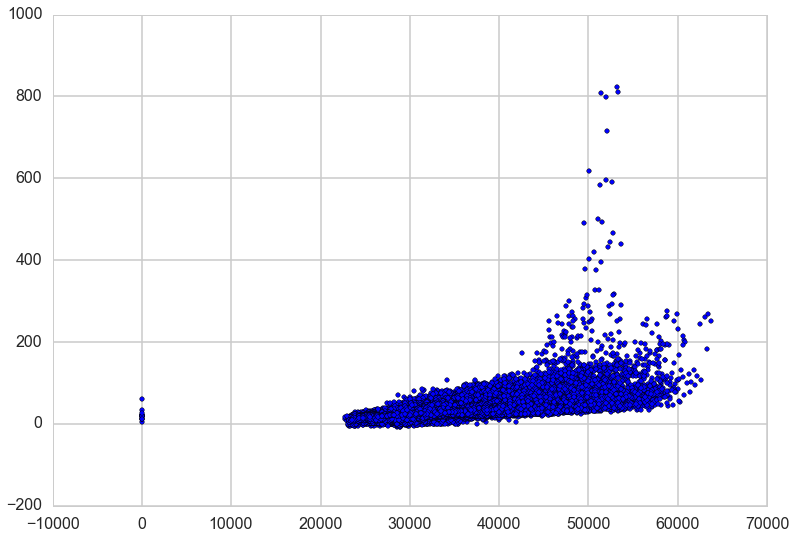

In [13]:
x = fulldf['Load_PJM_West']
y = fulldf['lmp_545']
plt.scatter(x,y)

## Add NG price data from Henry Hub

In [21]:
# Build empty Df with date index 
idx = pd.date_range('1/1/2008', '11/01/2015', freq = 'D')
ngdf = pd.DataFrame(index=idx)

# read in NG daily data
ng_raw = pd.read_csv('data/NGPrices.csv')
d = '2008-01-01'
ng_raw = ng_raw[ng_raw['date']>=d]
ng_raw['date'] = pd.to_datetime(ng_raw['date'])
ng_raw = ng_raw.set_index('date')

# map raw daily data to empty df with full dates, interpolate missing values
ngdf['NG_HH'] = ng_raw
ngdf = ngdf.interpolate(method='time')
ngdf.values[0] = ngdf.values[1]
ngdf.head()

# add a column for each hour of day
for i in range (23):
    ngdf[i] = ngdf['NG_HH']

# stack columns and replace index with hourly
ngdf = ngdf.stack()
idx = pd.date_range('1/1/2008', periods = len(ngdf), freq = 'H') 
ngdf.index = idx
print ngdf.tail()
print len(ngdf)

2015-11-01 19:00:00    1.98
2015-11-01 20:00:00    1.98
2015-11-01 21:00:00    1.98
2015-11-01 22:00:00    1.98
2015-11-01 23:00:00    1.98
Freq: H, dtype: float64
68688


In [22]:
fulldf['NG_HH'] = ngdf
fulldf.head()

,lmp_601,lmp_635,lmp_525,lmp_547,lmp_629,lmp_633,lmp_599,lmp_527,lmp_545,lmp_631,lmp_673,Wind_MISO,Wind_PJM,Load_PJM_West,NG_HH,Load_MISO_Central
2008-01-01 00:00:00,24.15,23.58,24.07,24.38,23.42,23.58,24.14,24.04,24.40,23.48,42.90,1104.05,697.102,33534,7.83,NaN
2008-01-01 01:00:00,23.10,22.46,23.03,23.31,22.37,22.45,23.10,23.00,23.33,22.43,39.33,1210.31,679.046,32632,7.83,NaN
2008-01-01 02:00:00,21.91,21.32,21.85,22.11,21.31,21.32,21.90,21.83,22.14,21.37,35.57,1173.34,632.607,31828,7.83,NaN
2008-01-01 03:00:00,21.08,20.48,21.02,21.26,20.51,20.48,21.08,21.00,21.29,20.56,34.19,1146.36,612.350,31565,7.83,NaN
2008-01-01 04:00:00,20.84,20.26,20.78,21.02,20.30,20.25,20.84,20.76,21.05,20.36,33.14,1179.32,620.483,31542,7.83,NaN


## Add MISO load data

In [113]:
mdf = pd.read_csv('data/Load_MISO_central_west.csv')
mdf.columns = ['date','Load_MISO_Central']
idx = pd.date_range('7/6/2009', periods = len(mdf), freq = 'H') 
mdf.index = idx
mdf = mdf.drop('date',1)
inds = pd.isnull(mdf).any(1).nonzero()[0]
mdf.iloc[inds[0]] = np.mean([mdf.iloc[inds[0]+1][0],mdf.iloc[inds[0]-1][0]])
fulldf['Load_MISO_Central'] = mdf
fulldf.head(2)

,lmp_601,lmp_635,lmp_525,lmp_547,lmp_629,lmp_633,lmp_599,lmp_527,lmp_545,lmp_631,lmp_673,Wind_MISO,Wind_PJM,Load_PJM_West,NG_HH,Load_MISO_Central
2008-01-01 00:00:00,24.15,23.58,24.07,24.38,23.42,23.58,24.14,24.04,24.40,23.48,42.90,1104.05,697.102,33534,7.83,NaN
2008-01-01 01:00:00,23.10,22.46,23.03,23.31,22.37,22.45,23.10,23.00,23.33,22.43,39.33,1210.31,679.046,32632,7.83,NaN


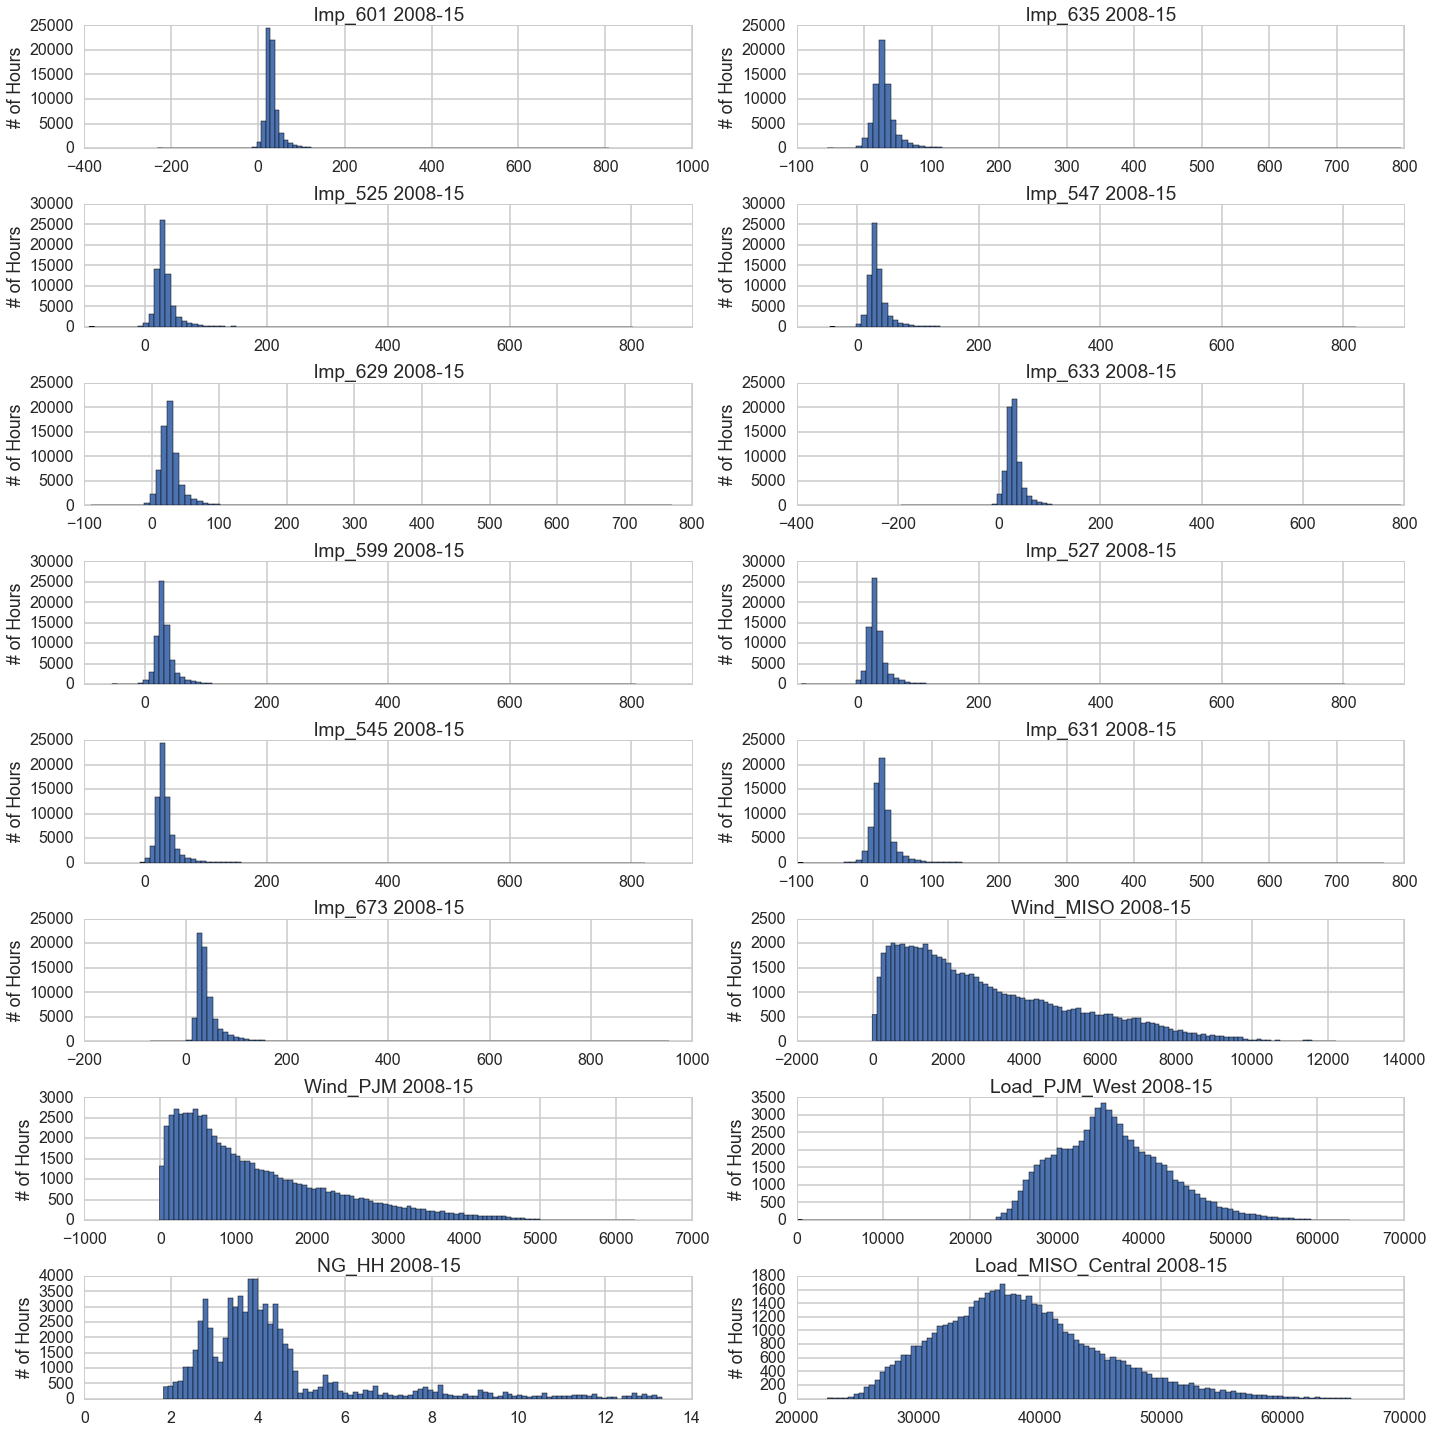

In [69]:
fig, axes = plt.subplots(nrows=8,ncols=2,figsize=(20,20),tight_layout=True)
headers = list(fulldf)
ax = axes.ravel()

for i in range(16):
    fulldf.iloc[:,i].hist(bins=100, ax=ax[i])
    ax[i].set_title(headers[i] + ' 2008-15')
    ax[i].set_ylabel("# of Hours")
    #ax[i].set_xlabel("MWh")

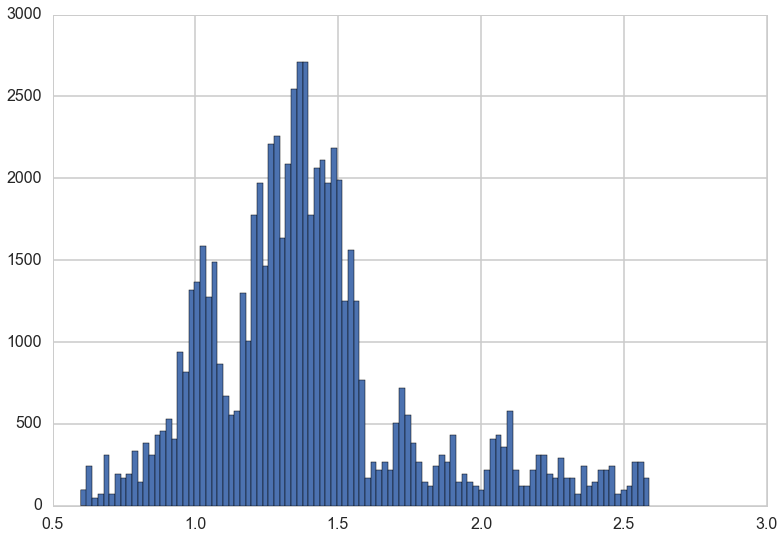

In [70]:
nglog = np.log(fulldf['NG_HH'])
nglog.hist(bins=100)

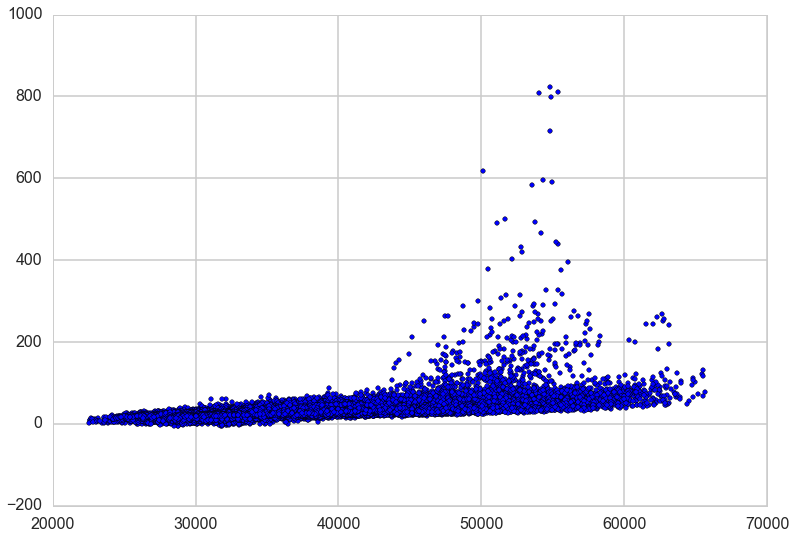

In [81]:
x = fulldf['Load_MISO_Central']
y = fulldf['lmp_545']
plt.scatter(x,y)

## Run Regressions

### At hourly granularity

In [114]:
import statsmodels.formula.api as smf

print "LMP_NODE    ", "   NG    ", "   PJM Load    ","   MISO Load    ","   PJM Wind    ","   MISO Wind   ", "   All minus MISO Load", "   All"
for lmp in list(fulldf)[0:11]:
    lm0 = smf.ols(formula = lmp + ' ~ NG_HH', data = fulldf).fit()
    lm1 = smf.ols(formula = lmp + ' ~ Load_PJM_West', data = fulldf).fit()
    lm2 = smf.ols(formula = lmp + ' ~ Load_MISO_Central', data = fulldf).fit()
    lm3 = smf.ols(formula = lmp + ' ~ Wind_PJM', data = fulldf).fit()
    lm4 = smf.ols(formula = lmp + ' ~ Wind_MISO', data = fulldf).fit()
    lm5 = smf.ols(formula = lmp + ' ~ NG_HH + Load_PJM_West + Wind_PJM + Wind_MISO', data = fulldf).fit()
    lm6 = smf.ols(formula = lmp + ' ~ NG_HH + Load_PJM_West + Wind_PJM + Wind_MISO + Load_MISO_Central', data = fulldf).fit()
    print lmp, ':   ', lm0.rsquared, lm1.rsquared, lm2.rsquared, lm3.rsquared, lm4.rsquared, lm5.rsquared, lm6.rsquared

LMP_NODE        NG        PJM Load        MISO Load        PJM Wind        MISO Wind       All minus MISO Load    All
lmp_601 :    0.13664482847 0.34620572281 0.290078550181 0.0201478007569 0.0135927467543 0.435310343873 0.352985173331
lmp_635 :    0.159301558177 0.329155632993 0.282749881936 0.024861203548 0.0179731376674 0.437568109972 0.347816772239
lmp_525 :    0.136691074531 0.348338790011 0.294900791651 0.0200874810571 0.013048372356 0.437612306379 0.356701680096
lmp_547 :    0.134559361165 0.34387336988 0.29261086215 0.0194835090026 0.0120322704513 0.432091395483 0.354193506586
lmp_629 :    0.192810476557 0.307364102778 0.258996817925 0.03616633027 0.0352346767823 0.444819294069 0.328633284306
lmp_633 :    0.158193987364 0.323338283856 0.274357738226 0.0252267470154 0.0193648057008 0.430846005993 0.337826072778
lmp_599 :    0.137459734166 0.348682177417 0.2945116266 0.021757928729 0.0146983444786 0.438118053149 0.35564500184
lmp_527 :    0.136597394166 0.34828465879 0.2951207546

### At daily granularity

In [115]:
d = '2009-07-06 00:00:00'
dfulldf = fulldf.ix[d:]
dfulldf = dfulldf.groupby(pd.TimeGrouper('D')).transform(np.mean).resample('D') #, how='ohlc'
print "number of hourly data points: ", len(fulldf)
print "number of daily data points: ", len(dfulldf)

number of hourly data points:  68688
number of daily data points:  2310


In [116]:
print "LMP_NODE    ", "   NG    ", "   PJM Load    ","   MISO Load    ","   PJM Wind    ","   MISO Wind   ", "   All minus MISO Load", "   All"
for lmp in list(dfulldf)[0:11]:
    lm0 = smf.ols(formula = lmp + ' ~ NG_HH', data = dfulldf).fit()
    lm1 = smf.ols(formula = lmp + ' ~ Load_PJM_West', data = dfulldf).fit()
    lm2 = smf.ols(formula = lmp + ' ~ Load_MISO_Central', data = dfulldf).fit()
    lm3 = smf.ols(formula = lmp + ' ~ Wind_PJM', data = dfulldf).fit()
    lm4 = smf.ols(formula = lmp + ' ~ Wind_MISO', data = dfulldf).fit()
    lm5 = smf.ols(formula = lmp + ' ~ NG_HH + Load_PJM_West + Wind_PJM + Wind_MISO', data = dfulldf).fit()
    lm6 = smf.ols(formula = lmp + ' ~ NG_HH + Load_PJM_West + Wind_PJM + Wind_MISO + Load_MISO_Central', data = dfulldf).fit()
    print lmp, ':   ', lm0.rsquared, lm1.rsquared, lm2.rsquared, lm3.rsquared, lm4.rsquared, lm5.rsquared, lm6.rsquared

LMP_NODE        NG        PJM Load        MISO Load        PJM Wind        MISO Wind       All minus MISO Load    All
lmp_601 :    0.147906256246 0.239728309669 0.200461114519 0.000887893495646 0.000361127950301 0.323020762437 0.323134125396
lmp_635 :    0.161191123665 0.214548972526 0.184523647162 0.00207270303243 0.00115487267919 0.31044674147 0.310789966789
lmp_525 :    0.148788612306 0.243324316544 0.207717944902 0.000906367826535 0.000209993541117 0.327755401349 0.328123640661
lmp_547 :    0.151433678153 0.240884505533 0.209857186041 0.000934885197086 0.000114857416985 0.328506402718 0.329216900792
lmp_629 :    0.180697094776 0.175178731621 0.146182491494 0.00489993630097 0.0113792693058 0.29042976952 0.290553042329
lmp_633 :    0.152111283297 0.20803774381 0.176973579056 0.00215543513677 0.00191346476672 0.296341218426 0.296616310676
lmp_599 :    0.144676584968 0.244750753583 0.206884574902 0.00150246208935 0.000640117803126 0.324607432108 0.324898477976
lmp_527 :    0.1486236020

In [61]:
for lmp in list(fulldf)[0:11]:
    lm = smf.ols(formula = lmp + ' ~ NG_HH + Load_PJM_West + Wind_PJM + Wind_MISO + Load_MISO_Central', data = fulldf).fit_regularized()
    #lm = smf.ols(formula = lmp + ' ~ NG_HH + Load_PJM_West + Wind_PJM + Wind_MISO', data = fulldf).fit()
    print lmp, ':   ', lm.rsquared_adj, lm.rsquared

lmp_601 :    0.352916804625 0.352975165604
lmp_635 :    0.3477505514 0.347809378328
lmp_525 :    0.356633129059 0.35669115486
lmp_547 :    0.354125035374 0.354183287382
lmp_629 :    0.328582429279 0.328642984997
lmp_633 :    0.337758993738 0.337818721813
lmp_599 :    0.35557757617 0.355635697172
lmp_527 :    0.356636730431 0.356694755907
lmp_545 :    0.358853782038 0.358911607556
lmp_631 :    0.329032649963 0.329093165074
lmp_673 :    0.281247190061 0.281312014983


## Ridge Regression

In [142]:
# Hourly
d = '2009-07-06 00:00:00'
lmp1df = fulldf.ix[d:]
lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West','Load_MISO_Central']]
#lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West']]
lmp1df.head(2)

,lmp_601,NG_HH,Wind_MISO,Wind_PJM,Load_PJM_West,Load_MISO_Central
2009-07-06 00:00:00,17.53,3.24,313.94,92.4,28391.908,26274.67
2009-07-06 01:00:00,10.86,3.24,288.85,82.8,26837.006,25008.58


In [143]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('lmp_601', axis=1), lmp1df['lmp_601'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  10.0

R2 Score:  0.32607872709
Explained Variance Score:  0.326079705828
MAE:  6.86819863452
MSE:  278.631448225
Median AE:  4.82522592396



,Predictors,Coefficients
0,NG_HH,4.379701
3,Load_PJM_West,0.001172
4,Load_MISO_Central,0.000460
1,Wind_MISO,0.000412
2,Wind_PJM,-0.000629


In [133]:
# Daily
d = '2009-07-06'
lmp1df = dfulldf.ix[d:]
lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West','Load_MISO_Central']]
#lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West']]
lmp1df.head(2)

,lmp_601,NG_HH,Wind_MISO,Wind_PJM,Load_PJM_West,Load_MISO_Central
2009-07-06,25.878750,3.24,325.927083,131.258333,35633.144917,34365.202917
2009-07-07,25.353333,3.30,511.056250,268.175000,36161.482625,35808.540000


In [136]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('lmp_601', axis=1), lmp1df['lmp_601'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  50.0

R2 Score:  0.356298789994
Explained Variance Score:  0.357038735286
MAE:  5.52091956543
MSE:  161.671739264
Median AE:  3.46189351071



,Predictors,Coefficients
0,NG_HH,4.667444
3,Load_PJM_West,0.001241
1,Wind_MISO,0.000807
4,Load_MISO_Central,0.000039
2,Wind_PJM,-0.000960


## Random Forest

In [144]:
d = '2009-07-06 00:00:00'
lmp1df = fulldf.ix[d:]
lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West','Load_MISO_Central']]
#lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West']]
lmp1df.head(2)

,lmp_601,NG_HH,Wind_MISO,Wind_PJM,Load_PJM_West,Load_MISO_Central
2009-07-06 00:00:00,17.53,3.24,313.94,92.4,28391.908,26274.67
2009-07-06 01:00:00,10.86,3.24,288.85,82.8,26837.006,25008.58


In [145]:
from sklearn.cross_validation import train_test_split
from sklearn import grid_search
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy import stats



# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('lmp_601', axis=1), lmp1df['lmp_601'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch
params = {
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [30,50,75,100],
        'max_depth': [None,1,2,3,5],
        'min_samples_split': [2,3,5]
}
clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), params, cv=5, n_jobs=1)
fit = clf.fit(X_train, y_train)


# Best Estimator
rf = fit.best_estimator_


# Metrics
print 'Best Params: ', fit.best_params_
print 'Best Score: ', fit.best_score_
print
preds = rf.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Feature Importances
lcols = X_train.columns
pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort('Feature Importances', ascending=False)

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.762204411777

R2 Score:  0.840363136508
Explained Variance Score:  0.840467531774
MAE:  4.49884997595
MSE:  66.0015527823
Median AE:  2.88753333333



,Predictors,Feature Importances
3,Load_PJM_West,0.334774
0,NG_HH,0.269030
4,Load_MISO_Central,0.230598
2,Wind_PJM,0.091983
1,Wind_MISO,0.073615


Just as with the Ridge Regression, we try Random Forest first on the full dataset grouped (averaged) at daily intervals

In [137]:
%%time
# Daily
d = '2009-07-06'
lmp1df = dfulldf.ix[d:]
lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West','Load_MISO_Central']]

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('lmp_601', axis=1), lmp1df['lmp_601'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch
params = {
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [30,50,75,100],
        'max_depth': [None,1,2,3,5],
        'min_samples_split': [2,3,5]
}
clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), params, cv=5, n_jobs=1)
fit = clf.fit(X_train, y_train)
rf = fit.best_estimator_

# Metrics
print 'Best Params: ', fit.best_params_
print 'Best Score: ', fit.best_score_
print
preds = rf.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Feature Importances
lcols = X_train.columns
pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort('Feature Importances', ascending=False)

Best Params:  {'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.520435164514

R2 Score:  0.585803760357
Explained Variance Score:  0.585813094656
MAE:  4.36783621408
MSE:  104.02936241
Median AE:  2.33287670414



,Predictors,Feature Importances
3,Load_PJM_West,0.410262
0,NG_HH,0.241690
4,Load_MISO_Central,0.213492
2,Wind_PJM,0.068929
1,Wind_MISO,0.065627
